## Genomic Data Science Specialization
Johns Hopkins University
# Course 3 : Algorithms for DNA Sequencing
###Module 2 : Preprocessing, indexing and approximate matching
## Practical: Implementing Boyer-Moore

The following gray box contains several functions that preprocess the pattern *P* and create the tables needed to apply the bad character and good suffix rules.  We won't discuss these, but if you are interested, see Chapter 2 of:

Gusfield, Dan. Algorithms on strings, trees and sequences: computer science and computational biology. Cambridge university press, 1997.

In [9]:
import string

def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]


def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp


def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]


def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab


class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """

    def __init__(self, p, alphabet='ACGT'):
        self.p = p
        self.alphabet = alphabet
        # Create map from alphabet characters to integers
        self.amap = {}
        for i in range(len(self.alphabet)):
            self.amap[self.alphabet[i]] = i
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)

    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        ci = self.amap[c]
        assert i > (self.bad_char[i][ci]-1)
        return i - (self.bad_char[i][ci]-1)

    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]

    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]

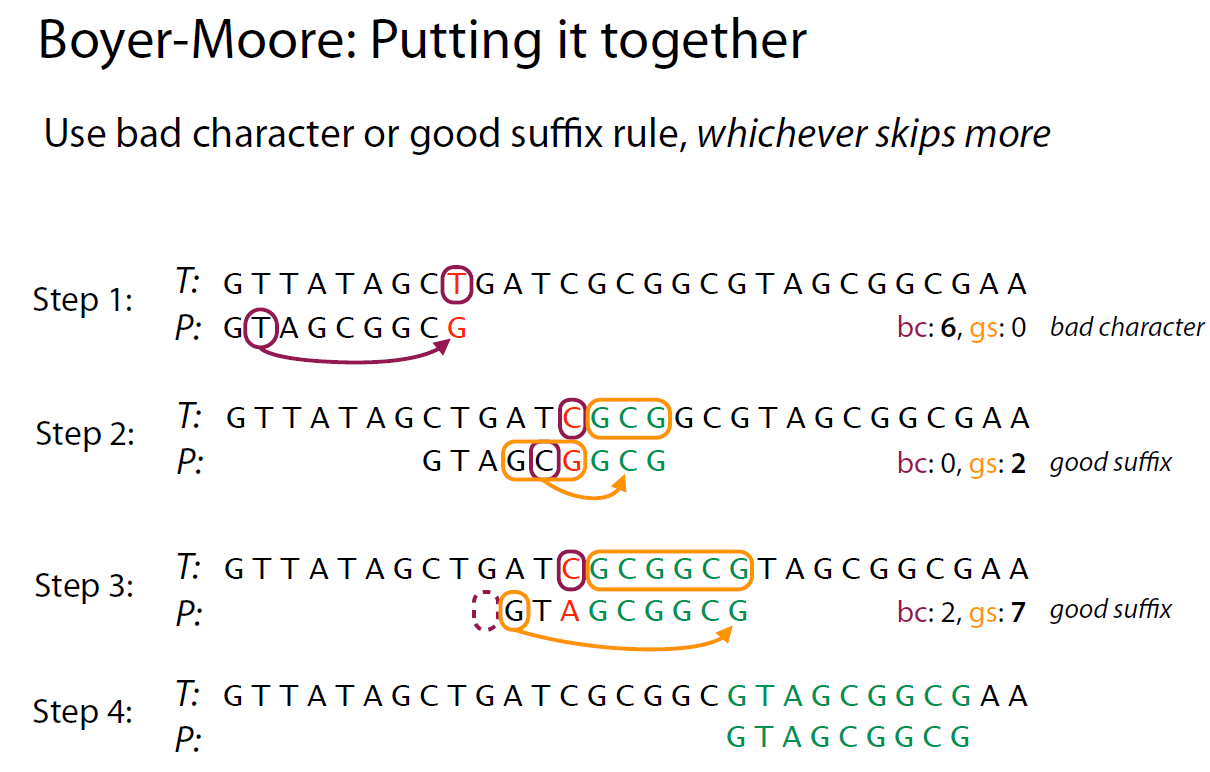

Image from https://github.com/BenLangmead/ads1-slides/blob/master/0225_exactmatch__boyer_moore_together.pdf

Let's make sure our rules give the expected results.

In [10]:
# GCTAGCTCTACGAGTCTA
p = 'TCAA'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.bad_character_rule(2, 'T')

2

In [11]:
# GCTAGCTCTACGAGTCTA
# ACTA
p = 'ACTA'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.good_suffix_rule(0)

3

In [12]:
# ACACGCTCTACGAGTCTA
# ACAC
p = 'ACAC'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.match_skip()

2

In [13]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences

In [14]:
t = 'GCTAGCTCTACGAGTCTA'
p = 'TCTA'
p_bm = BoyerMoore(p)
#p_bm = BoyerMoore(p, alphabet='ACGT')

In [15]:
boyer_moore(p, p_bm, t)

[6, 14]

In [17]:
t[6:10]

'TCTA'